In [1]:
import sys, os
sys.path += [os.path.dirname('../scripts/')]

import torch
from visualizer import CLS_tokens, plot_tokens_category
from transformers import ViTForImageClassification, ViTFeatureExtractor

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rk

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/CL_expression_z64_bs512/model/')
model = ViTForImageClassification.from_pretrained('../outputs/CL_expression_z64_bs512/model/')

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])

dataset = AffectNetDataset('../../Affectnet/validation.csv',
                           '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                           transform=transform)

In [5]:
features, labels = CLS_tokens(model.to(device), dataset, device)

100%|██████████| 4000/4000 [01:13<00:00, 54.07it/s]


In [6]:
features.shape

torch.Size([4000, 768])

In [7]:
labels.shape

torch.Size([4000])

In [8]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm


def plot_tokens_category_mds(tokens, labels, n_neighbors, id2label, random_seed):
    mds = MDS(n_components=2, random_state=random_seed)
    zs = mds.fit_transform(tokens.numpy())
    ys = labels.numpy()
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    ax.set_box_aspect(1)

    label2point = {}
    print('plotting tokens...')
    for x, y in tqdm(zip(zs, ys)):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    # fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.5))
    legend = ax.legend(handles, labels, loc='upper left',
                       bbox_to_anchor=(1, 0.5))
    return fig, legend

plotting tokens...


4000it [00:22, 178.40it/s]


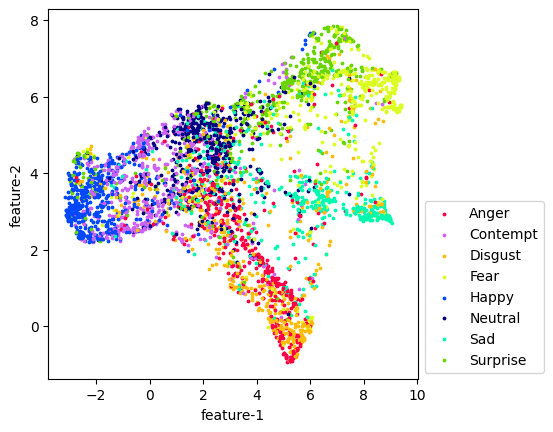

In [9]:
from utils import exclude_id

id2label, label2id = exclude_id([8,9,10])
fig, legend = plot_tokens_category(features, labels, 20, id2label, 0)